# Final Project

## By Team VC

### Intro to Co Purschaing Network | Toy reviews

For our final, we decided our analysis will use real world data supplied from the Amazon co-purchasing network. This network consisted of over 500 millions nodes with two types of nodes. The two node types are purchases and reviewers, as their connections are based on the reviews supplied by reviewers. Our starter network for the analysis is the Toy reviews sub network, so our limited scope is more susceptible for visual QAs. Let's begin our analysis!


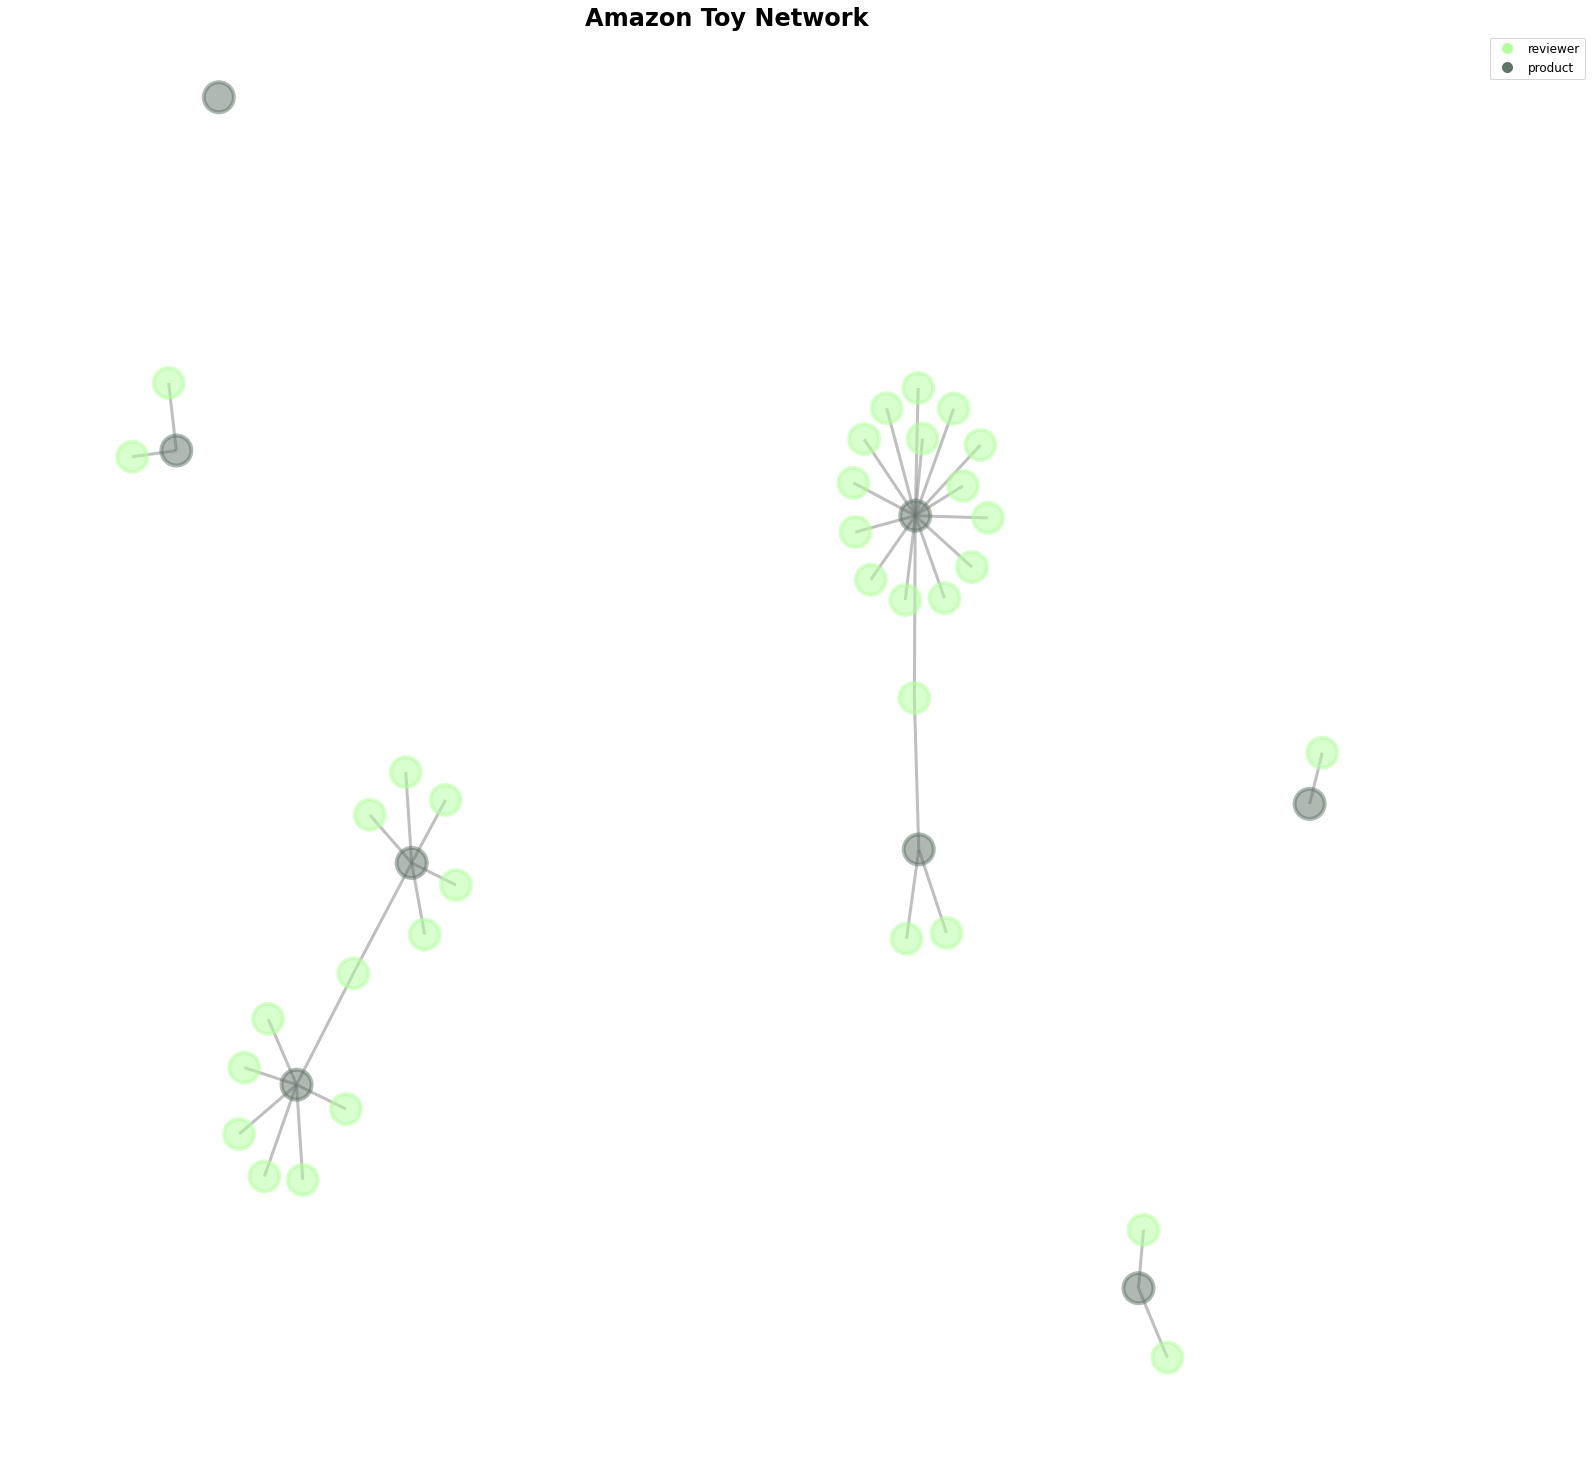

In [1]:
#Loading in our prep
import networkx as nx
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from networkx.algorithms import bipartite
import random
import nltk
import re

#Let's grab the product id as its label, for the cross matching later on
toy= nx.read_gml("amazon-toy.gml",label='label')
node_type=nx.get_node_attributes(toy,'type')

# Visualize the entire network
colors = []
color_map = { 'reviewer' : "#B2FF9E", 'product' : "#607466" }

for k in node_type:
    colors.append(color_map[node_type[k]])

plt.figure(figsize=(20, 20))

nx.draw(toy,
        font_size=18,
        font_weight="bold",
        font_color="black",
        node_size=900, 
        node_color=colors,
        edge_color="grey",
        node_shape="o", 
        alpha=0.5, 
        linewidths=4, 
        width=3)


legend_colors = list(color_map.values())
legend_texts = list(color_map.keys())

patches = [ plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=legend_colors[i], 
            label="{:s}".format(legend_texts[i]) )[0]  for i in range(len(legend_texts)) ]
plt.legend(
           handles=patches, 
           ncol=1, 
           numpoints=1, 
           fontsize = 12, 
           loc="upper right",
           bbox_to_anchor=(1.1, 1)
          )

plt.title("Amazon Toy Network", fontdict= { 'fontsize': 24, 'fontweight':'bold'}, loc='center')

plt.show()


### Developing out product list

For our analysis, lets sort the 2 node types for feature gathering. We created our product data frame with nodes of type 'product' filtered by node type. In this network, we can create our product list for the rating prediction and a dataframe for our product stats. The products stats will host any revelant data which can train the classifyer to predict the product's overall rating in Amazon's marketplace

In [2]:
#create a function that accepts a network graph to compute 
def product_create(G):
    product_list=[]
    product_details=[]
    P_Ids=[]
    p_l=[n for n, d in G.nodes(data=True) if d['type']=='product']
    p_g=G.subgraph(p_l)

    #creating a tuple list with only the product Id and overall product rating
    for n in p_g.nodes(data=True):
        product_list.append((n[0],n[1]['average_rating']))

    #gathering all details from the product nodes, will retrieve edge data from org list
    for n in p_g.nodes(data=True):
        P_Ids.append(n[0])
        product_details.append((n[0],n[1]['salesrank'],n[1]['reviews'],n[1]['title']))

    #the beginning of the product stats
    product_stats=pd.DataFrame(product_details,columns = ['Product_Id','Sales Rank','Review Count','Title'])
    return product_list,product_stats,P_Ids

product_list,product_stats,p_Ids=product_create(toy)
display(product_stats.head())

,Product_Id,Sales Rank,Review Count,Title
0,0963679600,59,16,IlluStory Book Kit
1,B000055XW3,31296,1,The Songs of Britney Spears & Christina Aguilera
2,B000075A8O,7812,2,Party Tyme Karaoke CD Kids Songs
3,0963679627,45241,0,R- Photostory Senior
4,B000053W7W,10732,6,Party Tyme Karaoke CD: V2 Super Hits


### Retrieval of product reviews

Now, we can focus our attention on the available reviews for the product. The edge attributes holds the reviewer's opinon on the product: the date of the review,their rating, how many people agree with their rating, and how many people found their review helpful. We can use these statistics to create more guessing metrics.  The edges stats table created three new feautres from our reviews: the most voted rating, the most helpful rating, and the earliest rating available.

Now, we can join the two tables with a inner left join!


In [3]:
#function that will retieve edge details 
def create_edetails(G,P_Ids):
    edge_details=[]
    edge_d=[]

    #if node is a product node, return its list of edge attributes into its own list
    for n in G.nodes(data=True):
        if n[0] in P_Ids:  
            #grab the edges from the specific node and apprend to edge details
            edges=G.edges(n[0],data=True)
            edges=list(edges)
            edge_d.append((edges))

    #In order to grab the edges features: We have to iterate down the nested list for each edge
    for e in edge_d:
        for i in range(len(e)):
            #for each value, retreive values from the nested dic
            edge_details.append((e[i][0],e[i][2]['date'],e[i][2]['rating'],e[i][2]['votes'],e[i][2]['helpful']))

    #display(edge_details)
    #Create the edge details table and left join with product details table by P_ID
    edge_stats=pd.DataFrame(edge_details,columns = ['Product_Id','Date','Rating','Votes','Helpful'])
    return edge_stats

edge_stats=create_edetails(toy,p_Ids)
display(edge_stats.head())

,Product_Id,Date,Rating,Votes,Helpful
0,B000075A8O,2004-3-29,5,4,4
1,B000075A8O,2004-6-19,5,3,3
2,B000055XW3,2001-2-26,3,2,2
3,0963679600,2004-7-12,5,27,25
4,0963679600,1999-6-25,5,20,20


In [4]:
#function to return top rankings based on 
def find_rates(P_Ids,e):
    rates=[]
    #Make rate values numeric
    e['Rating'] = pd.to_numeric(e['Rating'])
    e['Votes'] = pd.to_numeric(e['Votes'])
    e['Helpful'] = pd.to_numeric(e['Helpful'])
    for i in range(len(P_Ids)):
        if P_Ids[i] in e.values:
            #filter for the specific product id in the table
            temp= e[e['Product_Id'].str.contains(P_Ids[i])]
            #Retrieve top values from .max and .min
            rates.append((P_Ids[i],temp[temp['Votes']==temp.max()['Votes']]['Rating'].values[0],temp[temp['Helpful']==temp.max()['Helpful']]['Rating'].values[0],temp[temp['Date']==temp.min()['Date']]['Rating'].values[0]))
        else:
        #If the Product Id has no reviews, return all zeros
            rates.append((P_Ids[i],0,0,0))
    r=pd.DataFrame(rates,columns=['Product_Id','Most_Voted_Rating','Most_Helpful_Rating','Earliest_Rating'])
    return r
top_rates=find_rates(p_Ids,edge_stats)
display(top_rates.head())

#combine the two tables into one
master=pd.merge(product_stats, top_rates, on="Product_Id", how="left")
display(master)

,Product_Id,Most_Voted_Rating,Most_Helpful_Rating,Earliest_Rating
0,0963679600,5,5,5
1,B000055XW3,3,3,3
2,B000075A8O,5,5,5
3,0963679627,0,0,0
4,B000053W7W,5,5,5


,Product_Id,Sales Rank,Review Count,Title,Most_Voted_Rating,Most_Helpful_Rating,Earliest_Rating
0,0963679600,59,16,IlluStory Book Kit,5,5,5
1,B000055XW3,31296,1,The Songs of Britney Spears & Christina Aguilera,3,3,3
2,B000075A8O,7812,2,Party Tyme Karaoke CD Kids Songs,5,5,5
3,0963679627,45241,0,R- Photostory Senior,0,0,0
4,B000053W7W,10732,6,Party Tyme Karaoke CD: V2 Super Hits,5,5,5
5,1572810939,1890,2,Wizard Card Game Deluxe,5,5,5
6,B000059T05,4053,7,Party Tyme Karaoke CD Oldies,1,1,4
7,0963679678,2288,3,Photostory Junior Book Kit,5,5,5


### Features for predicting the products rating

### Expanding our learning into a larger network | DVD reviews

### Final takeaways